In [1]:
from sklearn.datasets import fetch_openml
import numpy as np


In [2]:
mnist = fetch_openml('mnist_784',version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y = mnist["data"], mnist["target"]
print(f"X: {X.shape} Y: {y.shape}")

X: (70000, 784) Y: (70000,)


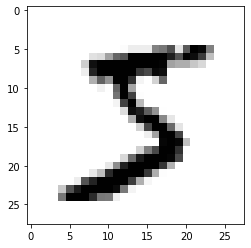

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

sample_digit = X.iloc[0].to_numpy()
sample_digit_image = sample_digit.reshape(28,28)
plt.imshow(sample_digit_image, cmap="binary")
plt.show()

In [5]:
#y is alpha but mnist784 is just numbers - need to convert to numeric
print(y[0])
y=y.astype(np.uint8)
print(y[0])

5
5


In [6]:
#mnist784 is already in random order, so just take the final 10k out of 70 k as test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


# Binary Classification

In [7]:
#binary classifier for "5"s
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)


SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([sample_digit])

array([ True])

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [10]:
cross_val_score(sgd_clf, X_train,y_train_5,cv=3,scoring="recall")

array([0.47039292, 0.63973437, 0.84338683])

In [11]:
#Getting confusion matrix using cross_val_predict
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5,y_train_pred)


array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

* 1891 false positives
* 687 false negatives

* Precision measures % of cases *classified* as TRUE that *are* true
* Recall: measures % of TRUE cases that are *classified* as True

In [12]:
from sklearn.metrics import precision_score, recall_score
print(f"Precision score: {precision_score(y_train_5,y_train_pred)}")
print(f"Recall score: {recall_score(y_train_5,y_train_pred)}")

Precision score: 0.8370879772350012
Recall score: 0.6511713705958311


* <b>F<sub>1</sub></b> score favours classifiers that have similar precision and recall
* This isn't always desirable (e.g. medical tests)

In [13]:
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)

0.7325171197343846

### Precision Recall curve

Use the PR curve when:
* Positive class is rare
* You care more abouyt false positives than false negatives

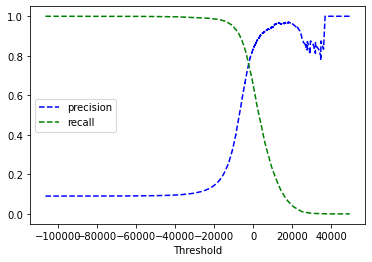

In [14]:
#Precision recall curve - is this the same as AUROC???
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1], 'b--', label = "precision")
    plt.plot(thresholds,recalls[:-1], 'g--', label = "recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.show()

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

* Recall always reduces as the threshold is raised
* Precision *can decrease* as the threshold is raised (true positives are removed)

In [15]:
#Aiming for 90% accuracy
threshold_90_precision=thresholds[np.argmax(precisions>=0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(f"Precision: {precision_score(y_train_5,y_train_pred_90)}")
print(f"Recall: {recall_score(y_train_5,y_train_pred_90)}")


Precision: 0.9000345901072293
Recall: 0.4799852425751706


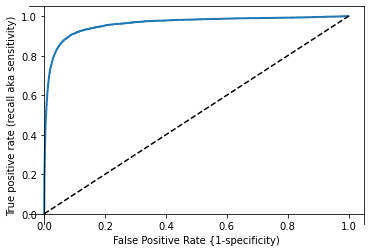

In [16]:
#ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    ax = plt.gca() #Get Current Axes
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    plt.xlabel("False Positive Rate {1-specificity)")
    plt.ylabel("True positive rate (recall aka sensitivity)")
    plt.show()

plot_roc_curve(fpr, tpr)


### Area Under Receiver Operating Characteristic (AUROC) (AUC)

* Perfect predicter would have 0 false positive with 1 recall - so area under curve would be 1.0

In [17]:

from sklearn.metrics import roc_auc_score

print(f"AUROC: {roc_auc_score(y_train_5,y_scores):.3f}")

AUROC: 0.960


AUROC of 0.96 looks really good, but it is misleading because the true positive rate is low. This mmeans that a classifier can rapidly reach a high rate of recall by finding a few true positive examples.

### RandomForestClassifier

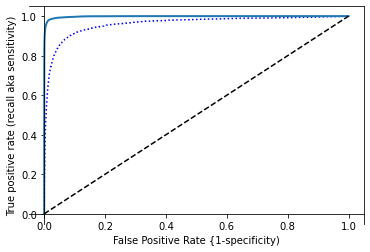

Random Forest AUROC: 0.998


In [18]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
# Random forest classifiers output probabilities for each class. 
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')
# Here there are 2 classes (negative and positive) so take the positive probability as score:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr,tpr,"b:",label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest,"Random Forest")
plt.show()
print(f"Random Forest AUROC: {roc_auc_score(y_train_5,y_scores_forest):.3f}")

In [19]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5,y_scores_forest)

threshold_99_precision=thresholds_forest[np.argmax(precisions_forest>=0.99)]
y_train_pred_99 = (y_scores_forest >= threshold_99_precision)
print(f"Forest Precision: {precision_score(y_train_5,y_train_pred_99):.3f}")
print(f"Forest Recall: {recall_score(y_train_5,y_train_pred_99):.3f}")

Forest Precision: 0.991
Forest Recall: 0.866


# Multi-class classification

In [20]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([sample_digit])


array([5], dtype=uint8)

In [21]:
sample_digit_scores = svm_clf.decision_function([sample_digit])
print(f"scores: {sample_digit_scores}")
print(f"highest score: {np.argmax(sample_digit_scores)}")
print(f"classification: {svm_clf.classes_[np.argmax(sample_digit_scores)]}")

scores: [[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
highest score: 5
classification: 5


In [22]:
#SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([sample_digit])


array([3], dtype=uint8)

In [23]:
sample_digit_scores = sgd_clf.decision_function([sample_digit])
print(f"scores: {sample_digit_scores}")
print(f"highest score: {np.argmax(sample_digit_scores)}")
print(f"classification: {sgd_clf.classes_[np.argmax(sample_digit_scores)]}")

scores: [[-15622.23821913 -31463.2371505   -7700.59171364   1433.409375
  -29315.7224787    -248.88329767 -25630.91118124 -19539.55009287
  -12668.25005761  -8102.58608507]]
highest score: 3
classification: 3


In [42]:
#cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.8589 , 0.86825, 0.87555])

In [24]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy', n_jobs=3)

array([0.8742 , 0.8544 , 0.88365])

In [25]:
#performance gain from adding standard scaling:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score is embarassingly parallel
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy', n_jobs=3)


array([0.898  , 0.89365, 0.9085 ])

In [26]:
sgd_clf.classes_


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [31]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3,n_jobs=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5579,    0,   23,    5,    9,   49,   37,    6,  214,    1],
       [   0, 6404,   37,   25,    4,   46,    4,    8,  201,   13],
       [  27,   27, 5236,   91,   71,   27,   66,   38,  367,    8],
       [  23,   16,  116, 5227,    2,  210,   27,   41,  397,   72],
       [  12,   14,   48,    9, 5200,   12,   34,   24,  325,  164],
       [  28,   15,   30,  165,   53, 4458,   74,   16,  521,   61],
       [  28,   15,   43,    3,   43,   98, 5554,    4,  129,    1],
       [  21,   11,   52,   30,   49,   13,    3, 5698,  176,  212],
       [  18,   67,   47,   88,    3,  130,   24,   10, 5422,   42],
       [  25,   19,   30,   68,  115,   35,    1,  184,  361, 5111]],
      dtype=int64)

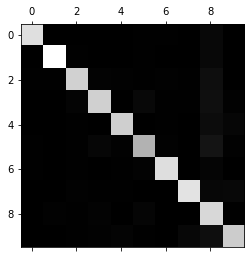

In [32]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

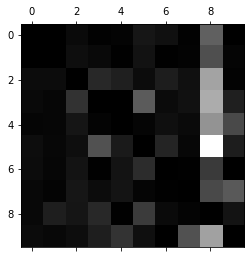

In [33]:
#Focus on the errors:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx,0)

plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

* Rows: ACTUAL
* Columns : PREDICTED

* Lots of other classes (especially 5s) are misidentified as 8s

In [49]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    #now need to explicitly convert dataframe to numpy
    images = [instance.reshape(size,size) for instance in instances.to_numpy()]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

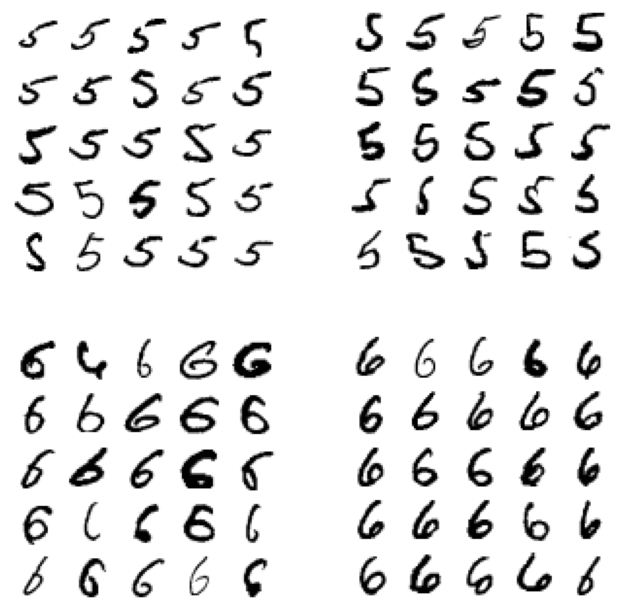

In [53]:
#Showing images for confusion matrix

cl_a, cl_b = 5,6

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(11,11))
plt.subplot(221); plot_digits(X_aa[:25],5)
plt.subplot(222); plot_digits(X_ab[:25],5)
plt.subplot(223); plot_digits(X_ba[:25],5)
plt.subplot(224); plot_digits(X_bb[:25],5)